**Step 1: Load and Explore the Dataset**

> Import the dataset and check for missing values and duplicates.




In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

# Display first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


> Drop missing CustomerID rows (since they are essential for segmentation).

In [3]:
df.dropna(subset=['CustomerID'], inplace=True)

**Step 2: Data Cleaning**

> 1. Convert InvoiceDate to DateTime format

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

> 2.Remove negative Quantity values (as they indicate returns).


In [5]:
df = df[df['Quantity'] > 0]

> 3.Create a TotalPrice column (Total revenue per transaction).

In [6]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

**Step 3: Feature Engineering (RFM Analysis)**

Since the dataset doesn’t have predefined customer segments, we need to extract meaningful features:

Recency – Days since the last purchase.
Frequency – Number of unique transactions per customer.
Monetary – Total spending per customer.

In [7]:
# Get the latest date in the dataset
latest_date = df['InvoiceDate'].max()

# Compute RFM values per CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (unique transactions)
    'TotalPrice': 'sum'  # Monetary (total spending)
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the first few rows
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


**Step 4: Data Preprocessing for Clustering**

> 1.Remove outliers (Optional but recommended).

In [8]:
# Remove extreme outliers using quantiles
rfm = rfm[(rfm['Monetary'] < rfm['Monetary'].quantile(0.99))]  # Remove top 1% spenders

> 2.Normalize the data (Required for K-Means).

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

**Step 5: Apply PCA for Dimensionality Reduction**

In [10]:
#Since RFM has three features, we reduce it to two principal components for better visualization.
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Convert PCA results into a DataFrame
rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
rfm_pca_df['CustomerID'] = rfm['CustomerID']

**Step 6: Determine the Optimal Number of Clusters (K)**

> A. Elbow Method

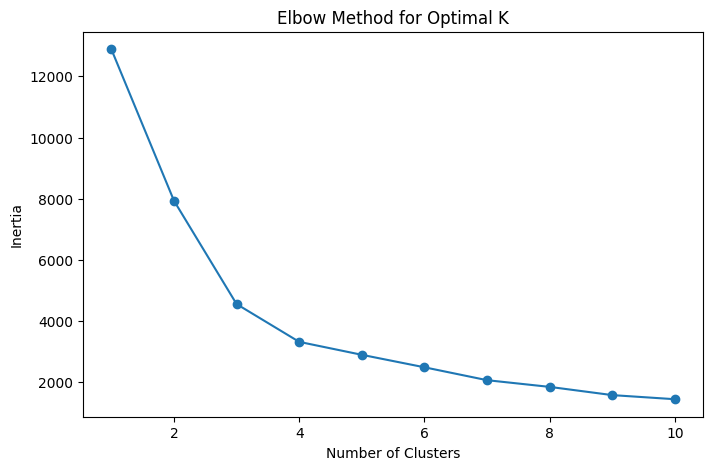

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

> B. Silhouette Score

In [12]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f'K={k}, Silhouette Score={score}')

K=2, Silhouette Score=0.6011724364635513
K=3, Silhouette Score=0.5307621263452456
K=4, Silhouette Score=0.5071403168511179
K=5, Silhouette Score=0.4376522387965764
K=6, Silhouette Score=0.43991800871326786
K=7, Silhouette Score=0.43854207659443417
K=8, Silhouette Score=0.4211834830444171
K=9, Silhouette Score=0.417114694483469
K=10, Silhouette Score=0.3886034530278199


**Step 7: Apply K-Means Clustering**

In [13]:
optimal_k = 3  # Example: Choose based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

**Step 8: Visualize the Customer Segments**

> A. PCA Scatter Plot

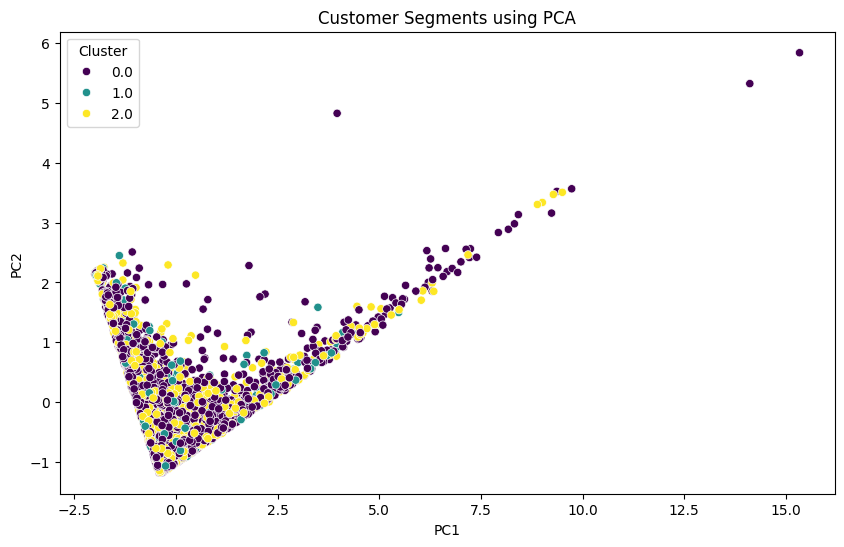

In [14]:
import seaborn as sns

rfm_pca_df['Cluster'] = rfm['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=rfm_pca_df, palette='viridis')
plt.title('Customer Segments using PCA')
plt.show()

> B. Boxplot for Monetary Value per Cluster

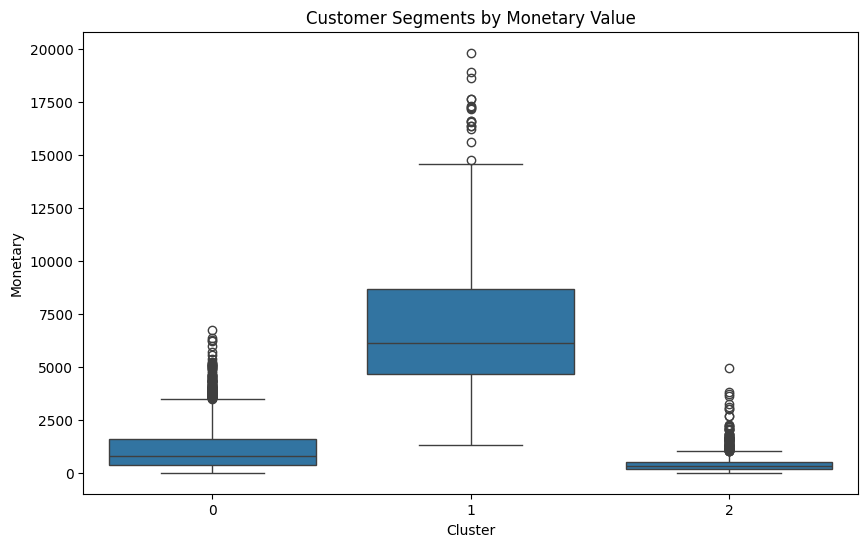

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Customer Segments by Monetary Value')
plt.show()

**Step 9: Interpret and Apply Insights**

> High-Value Customers (Cluster X): Frequent shoppers with high spending (Target with loyalty programs).

> Occasional Buyers (Cluster Y): Moderate frequency and spending (Target with promotions).

> Infrequent Buyers (Cluster Z): Rare purchases, low spending (Re-engagement strategies).

**Step 10: Save the Model for Future Use**

In [17]:
import joblib

joblib.dump(kmeans, 'customer_segmentation.pkl')

['customer_segmentation.pkl']